In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd 
import os 
import matplotlib.pyplot as plt
import matplotlib as mpl 
import time
import functools 
import IPython.display as display 
import PIL.Image 


In [ ]:

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



**TASK: **
>Transforming an Image to look like a Monet Painting 
>Generative Adversarial Networks -

** Code Workflow and Inital Notes **
>Want to create this in tensorFlow -> Good Practice Problem 

V0.1 
>Create a program that is able to to do basic neural style transfer following tensor flow documentation
>This is not optimized and there is a better way of doing this similar to cyclegan which generates an image in a particular style rather than transfering the style over 

**GAN Notes **
>Generative Adversarial Networks -> Two Models trained simultaneously 
>Generator (Artist Network) -> Learns to create images that look real
>Discriminator (Critic Network) -> Learns to tell real images apart from fakes 
> More Clearly We are trying to neural style transfer referenced in Gatys et al. 

* Coding Notes & Structure Notes * 
>Rather than getting into direct coding define tasks that will be repeated multiple times throughout the process and convert them into functions 

Definition: Tensor to Image 
>Takes in a tensor and returns an image 

Notes:
PIL.Image -> Python Imaging Library > Image class a
>General Image Editing Capabilities, in this case we are using PIL.Image.fromarray - > to turn an array(our tensor turned into np.array) into an image 

>tensor = tensor*255 -> Our tensor will most likely be normalized due to easier processsing so we will need to unnormalize 

>dont know what the assert is doing exactly but it seems to be reshaping tensor to an array format for .fromarray code 

In [3]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype = np.uint8)
    if np.ndim(tensor>3):
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return PIL.Image.fromarray(tensor)

Definition : Load an Image from Path and limit its dimension to 512 pixels 

In [4]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim/long_dim
    
    new_shape = tf.cast(shape*scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

Definition: Imshow -> Pretty obvious haha

In [5]:
def imshow(image, title = None):
    if len(image.shape)>3:
        image = tf.squeeze(image, axis = 0)
    
    plt.imshow(image)
    if title:
        plt.title(title)

Code Snippet to Load Two Images 
>We will choose one from content and one from style

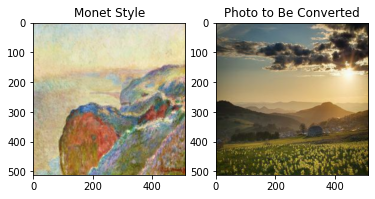

In [7]:
style_image = load_img("../input/gan-getting-started/monet_jpg/000c1e3bff.jpg")
content_image = load_img("../input/gan-getting-started/photo_jpg/00068bc07f.jpg")

plt.subplot(1,2,1)
imshow(style_image, "Monet Style")

plt.subplot(1,2,2)
imshow(content_image, "Photo to Be Converted")

In [8]:
vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')

print()
for layer in vgg.layers:
    print(layer.name)

80150528/80134624 [==============================] - 1s 0us/step

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


The above code represents a already created network from tensor flow, CNN for image classification, we removed the classification layer and will now choose intermediate layers to represent style and content of the image 

In [10]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

Definition: Creating a Pretrained Model 

In [11]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [13]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print(" Shape: ", output.numpy().shape)
    print(" min: ", output.numpy().min())
    print("max: ", output.numpy().max())
    print("mean: ", output.numpy().mean())
    print()
    


2022-06-07 16:38:18.827192: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


block1_conv1
 Shape:  (1, 512, 512, 64)
 min:  0.0
max:  760.72974
mean:  28.934137

block2_conv1
 Shape:  (1, 256, 256, 128)
 min:  0.0
max:  2488.955
mean:  140.94269

block3_conv1
 Shape:  (1, 128, 128, 256)
 min:  0.0
max:  7977.129
mean:  111.99371

block4_conv1
 Shape:  (1, 64, 64, 512)
 min:  0.0
max:  14338.058
mean:  464.30194

block5_conv1
 Shape:  (1, 32, 32, 512)
 min:  0.0
max:  2047.9188
mean:  30.573925



Definition: Calculate Style 

Content of an image is represented by the values of the intermediate feature maps.

Style can be described by the means and correlations across the different feature maps. 

Gram Matrix - > Includes this information -> Outer Product of the feature vector with itself at each location, and averaging the outer product over all locations 

Implemented - > using tf.linalg.einsum

In [14]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc, bijd -> bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result/(num_locations)

#First calculates Gram Matrix
#Then last two lines average values by figuring out dims

Extracting Style and Content 

Building a model that returns the style and content tensors

In [15]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers+content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False
        
    def call(self, inputs):
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                         outputs[self.num_style_layers:])
    
        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]
        
        content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}
        
        style_dict = {style_name: value 
                     for style_name, value 
                     in zip(self.style_layers, style_outputs)}
        
        return { 'content': content_dict, 'style': style_dict}

Gradient Descent Step 

Setting Style and Content Target Values

In [16]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.006153512
    max:  11840.152
    mean:  253.06909

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  40085.33
    mean:  8005.866

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  203216.48
    mean:  6659.395

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  2279912.5
    mean:  108155.984

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  42995.97
    mean:  611.7463

Contents:
   block5_conv2
    shape:  (1, 32, 32, 512)
    min:  0.0
    max:  513.11896
    mean:  8.565882


In [17]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [18]:
image = tf.Variable(content_image)

Definition: Clips pixel values between 0 and 1 

In [19]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)

Creating an optimizer (ADAM but LBFGS recommended)

In [20]:
opt = tf.optimizers.Adam(learning_rate = .02, beta_1= .99, epsilon = 1e-1)

In [21]:
style_weight=1e-2
content_weight=1e4


def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / 5

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / 1
    loss = style_loss + content_loss
    return loss

Updating the Image 

@tf.function()
Compiles a function into a callable TensorFlow graph. 


In [22]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape: 
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        
    grad = tape.gradient(loss,image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

2022-06-07 16:38:52.066463: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


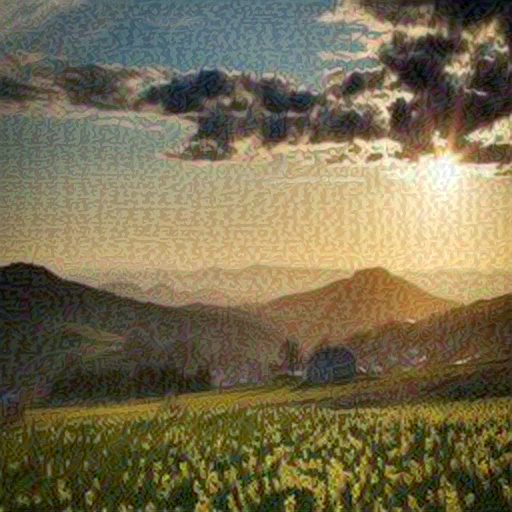

In [23]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

Total Variation Loss 

Removal of high frequency artifacts 

45626.12

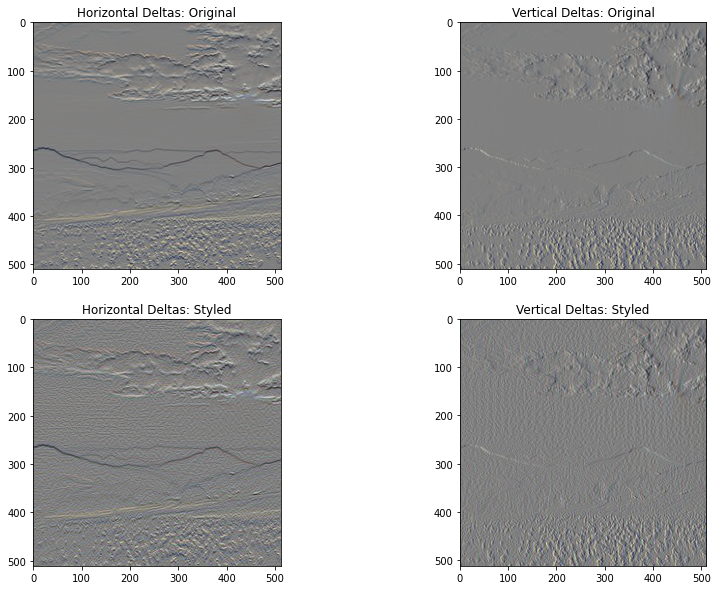

In [24]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
imshow(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
imshow(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_loss(image).numpy()


In [25]:
tf.image.total_variation(image).numpy()

array([45626.12], dtype=float32)

Rerunning Optimization

In [26]:
total_variation_weight=30
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))
image = tf.Variable(content_image)


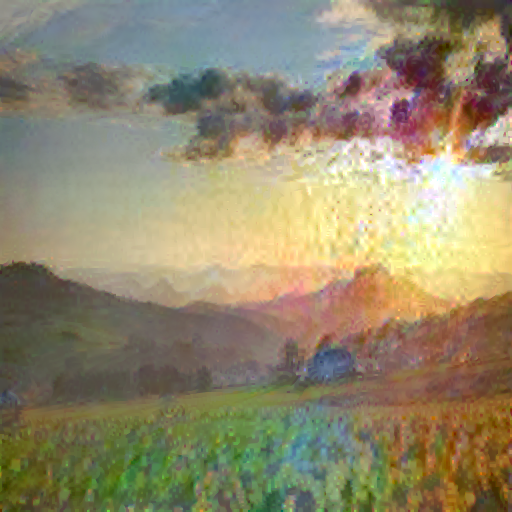

Train step: 1000
Total time: 44.3


In [27]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))
